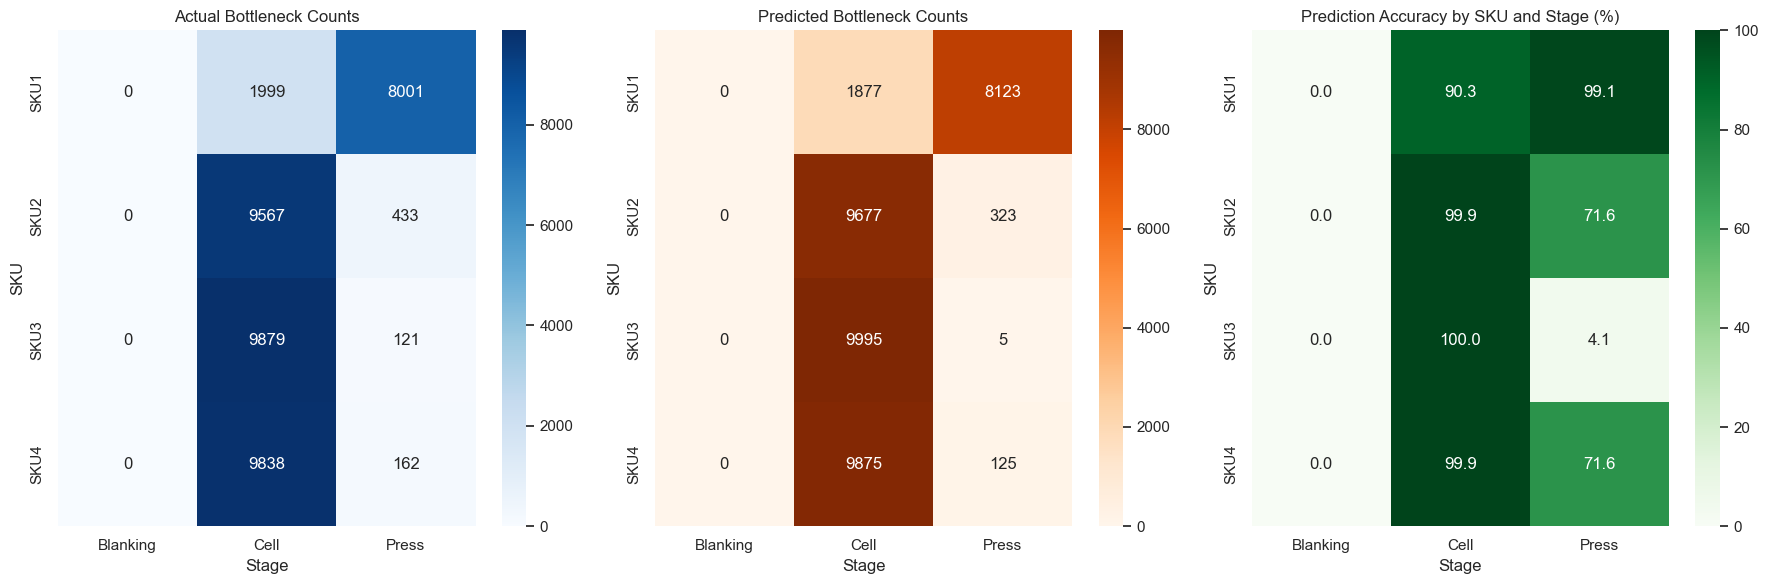

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# ================================
# 1. 데이터 로드
# ================================
file_path = "./Final Results Extended.csv"
df = pd.read_csv(file_path)

# ================================
# 2. SKU 경로 및 Cell 매핑 정의
# ================================
sku_paths = {
    "SKU1": {"blanking": "Blanking_SKU1_Queue","press": "Press1_Queue"},
    "SKU2": {"blanking": "Blanking_SKU2_Queue","press": "Press2_Queue"},
    "SKU3": {"blanking": "Blanking_SKU3_Queue","press": "Press3_Queue"},
    "SKU4": {"blanking": "Blanking_SKU4_Queue","press": "Press4_Queue"},
}

cell_sku_map = {
    "Warehouse1_Queue": ["SKU1", "SKU2", "SKU4"],  # Cell1
    "Warehouse_2_Queue": ["SKU2", "SKU4"],         # Cell2
    "Warehouse_3_Queue": ["SKU2", "SKU3"],         # Cell3
    "Warehouse_4_Queue": ["SKU3", "SKU4"],         # Cell4
}

# ================================
# 3. Warehouse 분배 벡터화
# ================================
sku_cell_vals = {sku: pd.Series(0, index=df.index) for sku in sku_paths}
for wh_col, skus in cell_sku_map.items():
    share = df[wh_col] / len(skus)
    for s in skus:
        sku_cell_vals[s] += share

# ================================
# 4. 병목 Stage 라벨 생성 (벡터화)
# ================================
labels = {}
for sku, path in sku_paths.items():
    blanking = df[path["blanking"]]
    press = df[path["press"]]
    cell = sku_cell_vals[sku]
    stage_df = pd.DataFrame({"Blanking": blanking, "Press": press, "Cell": cell})
    labels[sku] = stage_df.fillna(float("-inf")).idxmax(axis=1)

# ================================
# 5. Feature 선택
# ================================
feature_cols = [
    "Blanking_SKU1_Queue","Blanking_SKU2_Queue","Blanking_SKU3_Queue","Blanking_SKU4_Queue",
    "Press1_Queue","Press2_Queue","Press3_Queue","Press4_Queue",
    "Warehouse1_Queue","Warehouse_2_Queue","Warehouse_3_Queue","Warehouse_4_Queue",
    "Forklift_Blanking_Queue","Forklift_Press_Queue","Forklift_Assembly_Queue"
]
X_full = df[feature_cols]

# 속도 위해 샘플링 (필요 시 sample_size 조절)
sample_size = 50000
df_sample = df.sample(n=sample_size, random_state=42)
X = df_sample[feature_cols]

# ================================
# 6. 학습 + 집계
# ================================
acc_records, actual_records, pred_records = [], [], []

for sku in sku_paths.keys():
    y = labels[sku].loc[df_sample.index]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    clf = RandomForestClassifier(
        n_estimators=100, max_depth=15, random_state=42, n_jobs=-1
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Accuracy per Stage
    cm = confusion_matrix(y_test, y_pred, labels=["Blanking","Press","Cell"])
    acc = np.divide(cm.diagonal(), cm.sum(axis=1),
                    out=np.zeros_like(cm.diagonal(), dtype=float),
                    where=cm.sum(axis=1)!=0)
    for stage, val in zip(["Blanking","Press","Cell"], acc):
        acc_records.append({"SKU": sku, "Stage": stage, "Accuracy": val})

    # Stage Counts
    true_counts = pd.Series(y_test).value_counts()
    pred_counts = pd.Series(y_pred).value_counts()
    for stage in ["Blanking","Press","Cell"]:
        actual_records.append({"SKU": sku, "Stage": stage, "Count": true_counts.get(stage,0)})
        pred_records.append({"SKU": sku, "Stage": stage, "Count": pred_counts.get(stage,0)})

# Pivot 변환
acc_df = pd.DataFrame(acc_records).pivot(index="SKU", columns="Stage", values="Accuracy")
actual_counts = pd.DataFrame(actual_records).pivot(index="SKU", columns="Stage", values="Count")
pred_counts = pd.DataFrame(pred_records).pivot(index="SKU", columns="Stage", values="Count")

# ================================
# 7. Dashboard Plot (3패널)
# ================================
fig, axes = plt.subplots(1, 3, figsize=(18,6))

sns.heatmap(actual_counts, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Actual Bottleneck Counts")

sns.heatmap(pred_counts, annot=True, fmt="d", cmap="Oranges", ax=axes[1])
axes[1].set_title("Predicted Bottleneck Counts")

sns.heatmap(acc_df*100, annot=True, fmt=".1f", cmap="Greens", ax=axes[2])
axes[2].set_title("Prediction Accuracy by SKU and Stage (%)")

plt.tight_layout()
plt.show()

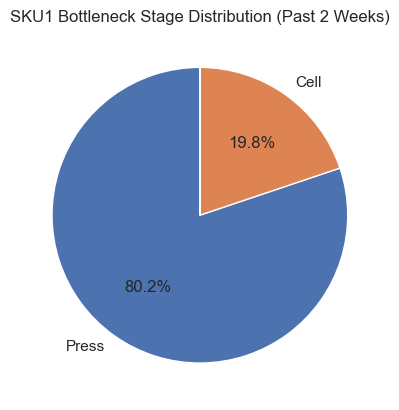

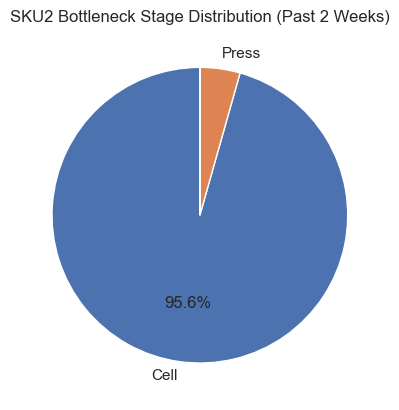

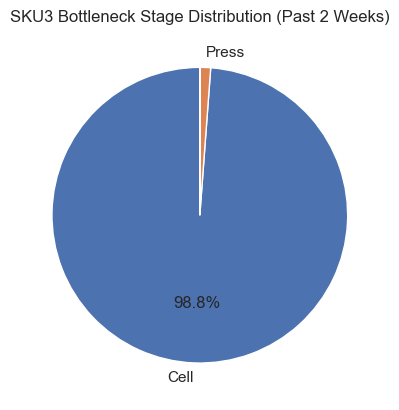

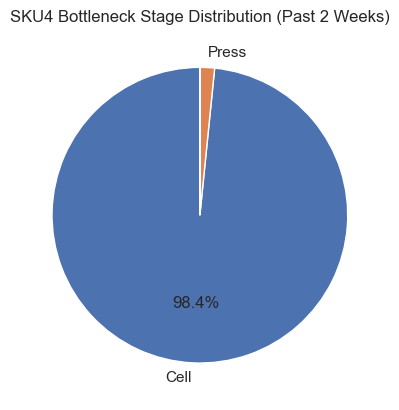

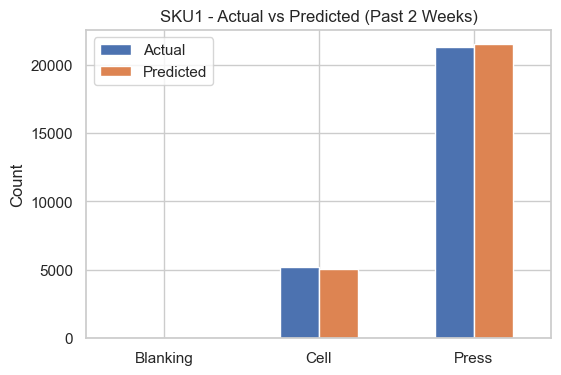

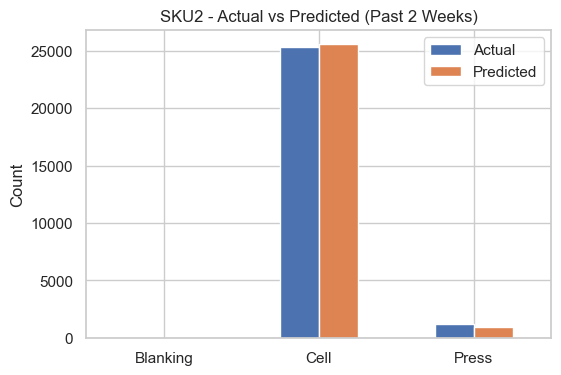

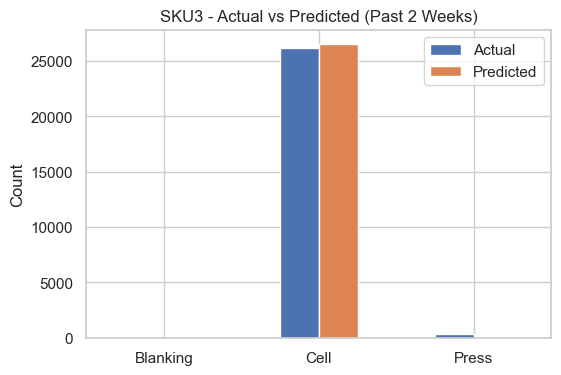

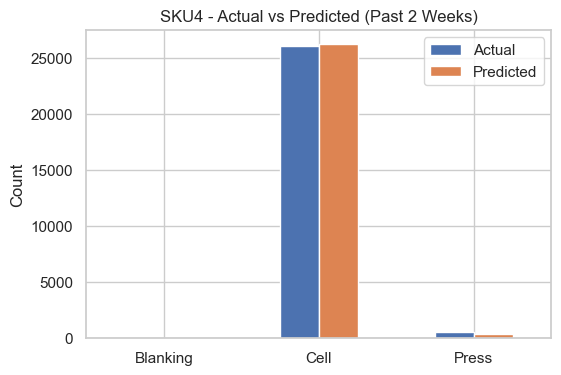

오늘 날짜: 1970-01-01

SKU1 오늘 병목 Stage 예측 분포:
Press    106857
Cell      25819
Name: count, dtype: int64

SKU2 오늘 병목 Stage 예측 분포:
Cell     126859
Press      5817
Name: count, dtype: int64

SKU3 오늘 병목 Stage 예측 분포:
Cell     131314
Press      1362
Name: count, dtype: int64

SKU4 오늘 병목 Stage 예측 분포:
Cell     130560
Press      2116
Name: count, dtype: int64


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import datetime

# ================================
# 1. 데이터 로드
# ================================
file_path = "./Final Results Extended.csv"
df = pd.read_csv(file_path)

# Time 컬럼 datetime 변환 (데이터에 맞게 수정)
df["Time_Now"] = pd.to_datetime(df["Time_Now"])

# ================================
# 2. SKU 경로 및 Cell 매핑 정의
# ================================
sku_paths = {
    "SKU1": {"blanking": "Blanking_SKU1_Queue","press": "Press1_Queue"},
    "SKU2": {"blanking": "Blanking_SKU2_Queue","press": "Press2_Queue"},
    "SKU3": {"blanking": "Blanking_SKU3_Queue","press": "Press3_Queue"},
    "SKU4": {"blanking": "Blanking_SKU4_Queue","press": "Press4_Queue"},
}

cell_sku_map = {
    "Warehouse1_Queue": ["SKU1", "SKU2", "SKU4"],
    "Warehouse_2_Queue": ["SKU2", "SKU4"],
    "Warehouse_3_Queue": ["SKU2", "SKU3"],
    "Warehouse_4_Queue": ["SKU3", "SKU4"],
}

# ================================
# 3. Warehouse 분배 벡터화
# ================================
sku_cell_vals = {sku: pd.Series(0, index=df.index) for sku in sku_paths}
for wh_col, skus in cell_sku_map.items():
    share = df[wh_col] / len(skus)
    for s in skus:
        sku_cell_vals[s] += share

# ================================
# 4. 병목 Stage 라벨 생성
# ================================
labels = {}
for sku, path in sku_paths.items():
    stage_df = pd.DataFrame({
        "Blanking": df[path["blanking"]],
        "Press": df[path["press"]],
        "Cell": sku_cell_vals[sku]
    })
    labels[sku] = stage_df.fillna(float("-inf")).idxmax(axis=1)

# ================================
# 5. 과거 2주 필터링
# ================================
end_date = df["Time_Now"].max()
start_date = end_date - pd.Timedelta(days=14)
df_past = df[(df["Time_Now"] >= start_date) & (df["Time_Now"] <= end_date)]

# ================================
# 6. 과거 2주 기준 SKU별 병목 Stage 분포 (실제)
# ================================
for sku in sku_paths.keys():
    past_labels = labels[sku].loc[df_past.index]
    counts = past_labels.value_counts()

    # 레이블 조건: Blanking 비율 낮으면 제외
    total = counts.sum()
    labels_to_show = []
    for stage, val in counts.items():
        ratio = val / total
        if stage == "Blanking" and ratio < 0.05:  # 5% 미만이면 레이블 숨김
            labels_to_show.append("")  
        else:
            labels_to_show.append(stage)

    plt.figure()
    plt.pie(counts, labels=labels_to_show, autopct=lambda p: f"{p:.1f}%" if p > 5 else "", 
            startangle=90)
    plt.title(f"{sku} Bottleneck Stage Distribution (Past 2 Weeks)")
    plt.show()

# ================================
# 7. 실제 vs 예측 (과거 2주)
# ================================
feature_cols = [
    "Blanking_SKU1_Queue","Blanking_SKU2_Queue","Blanking_SKU3_Queue","Blanking_SKU4_Queue",
    "Press1_Queue","Press2_Queue","Press3_Queue","Press4_Queue",
    "Warehouse1_Queue","Warehouse_2_Queue","Warehouse_3_Queue","Warehouse_4_Queue",
    "Forklift_Blanking_Queue","Forklift_Press_Queue","Forklift_Assembly_Queue"
]

X_past = df_past[feature_cols]

for sku in sku_paths.keys():
    y_past = labels[sku].loc[df_past.index]

    X_train, X_test, y_train, y_test = train_test_split(
        X_past, y_past, test_size=0.2, random_state=42
    )
    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    compare_df = pd.DataFrame({
        "Actual": pd.Series(y_test).value_counts(),
        "Predicted": pd.Series(y_pred).value_counts()
    }).fillna(0)

    compare_df.plot(kind="bar", figsize=(6,4))
    plt.title(f"{sku} - Actual vs Predicted (Past 2 Weeks)")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()

# ================================
# 8. 오늘의 SKU별 병목 Stage 예측
# ================================
df_today = df[df["Time_Now"].dt.date == end_date.date()]
X_today = df_today[feature_cols]

print("오늘 날짜:", end_date.date())
for sku in sku_paths.keys():
    y_all = labels[sku]  # 전체 라벨
    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_full, y_all)  # 전체 데이터로 학습
    preds_today = clf.predict(X_today)
    counts_today = pd.Series(preds_today).value_counts()
    print(f"\n{sku} 오늘 병목 Stage 예측 분포:")
    print(counts_today)

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# -----------------------------
# 1. 과거 2주 Actual vs Predicted (표)
# -----------------------------
past_result_tables = {}

for sku in sku_paths.keys():
    y_past = labels[sku].loc[df_past.index]
    X_past = df_past[feature_cols]

    X_train, X_test, y_train, y_test = train_test_split(
        X_past, y_past, test_size=0.2, random_state=42
    )

    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    compare_df = pd.DataFrame({
        "Actual": pd.Series(y_test).value_counts(),
        "Predicted": pd.Series(y_pred).value_counts()
    }).fillna(0).astype(int)

    past_result_tables[sku] = compare_df

# -----------------------------
# 2. 오늘 데이터 예측 (표)
# -----------------------------
df_today = df[df["Time_Now"].dt.date == end_date.date()]
X_today = df_today[feature_cols]

today_result_tables = {}
for sku in sku_paths.keys():
    y_all = labels[sku]
    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_full, y_all)
    preds_today = clf.predict(X_today)
    counts_today = pd.Series(preds_today).value_counts()
    today_result_tables[sku] = counts_today

# -----------------------------
# 3. 출력
# -----------------------------
print("=== 과거 2주간 Actual vs Predicted 병목 Stage (SKU별) ===\n")
for sku, table in past_result_tables.items():
    print(f"[{sku}]")
    print(table, "\n")

print("\n=== 오늘 병목 Stage 예측 (SKU별) ===\n")
for sku, table in today_result_tables.items():
    print(f"[{sku}]")
    print(table, "\n")

=== 과거 2주간 Actual vs Predicted 병목 Stage (SKU별) ===

[SKU1]
          Actual  Predicted
Blanking       1          0
Cell        5222       5022
Press      21313      21514 

[SKU2]
          Actual  Predicted
Blanking       1          0
Cell       25324      25561
Press       1211        975 

[SKU3]
          Actual  Predicted
Blanking       1          0
Cell       26207      26503
Press        328         33 

[SKU4]
          Actual  Predicted
Blanking       1          0
Cell       26055      26191
Press        480        345 


=== 오늘 병목 Stage 예측 (SKU별) ===

[SKU1]
Press    106857
Cell      25819
Name: count, dtype: int64 

[SKU2]
Cell     126859
Press      5817
Name: count, dtype: int64 

[SKU3]
Cell     131314
Press      1362
Name: count, dtype: int64 

[SKU4]
Cell     130560
Press      2116
Name: count, dtype: int64 



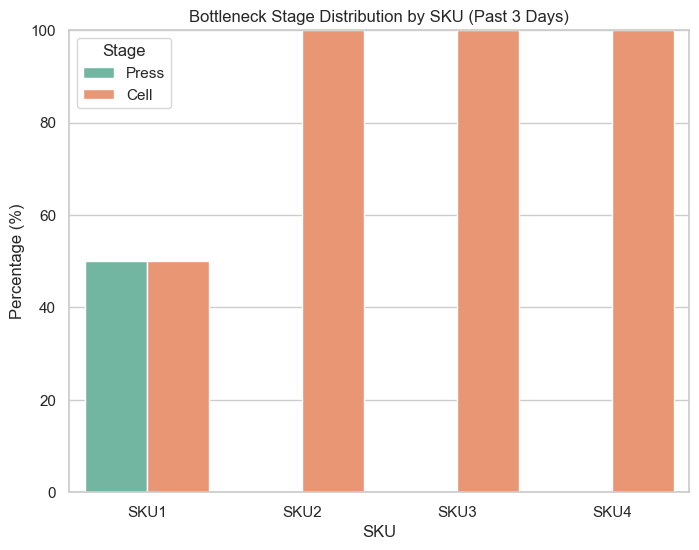

=== 과거 3일간 날짜별 Actual/Predicted + 오늘 예측 Stage ===

+----+-------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+---------+
|    | SKU   | 06-27_A   | 06-28_A   | 06-29_A   | 06-30_A   | 06-27_P   | 06-28_P   | 06-29_P   | 06-30_P   | Today   |
+====+=======+===========+===========+===========+===========+===========+===========+===========+===========+=========+
|  0 | SKU1  | Press     | Cell      | Press     | Cell      | Press     | Cell      | Press     | Cell      | Cell    |
+----+-------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+---------+
|  1 | SKU2  | Cell      | Cell      | Cell      | Cell      | Cell      | Cell      | Cell      | Cell      | Cell    |
+----+-------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+---------+
|  2 | SKU3  | Cell      | Cell      | Cell      | Cell      | Cell      | Cell      | Cell      | Cel

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate

# ================================
# 1. 데이터 로드
# ================================
file_path = "./subset_20240101_20250630_fullcols.csv"
df = pd.read_csv(file_path)

# 날짜 변환
df["Time_Now"] = pd.to_datetime(df["Time_Now"])

# 하루당 1행만 남기기 (마지막 row 기준)
df_daily = df.groupby(df["Time_Now"].dt.date).tail(1).reset_index(drop=True)

# ================================
# 2. SKU 경로 및 Cell 매핑 정의
# ================================
sku_paths = {
    "SKU1": {"blanking": "Blanking_SKU1_Queue","press": "Press1_Queue"},
    "SKU2": {"blanking": "Blanking_SKU2_Queue","press": "Press2_Queue"},
    "SKU3": {"blanking": "Blanking_SKU3_Queue","press": "Press3_Queue"},
    "SKU4": {"blanking": "Blanking_SKU4_Queue","press": "Press4_Queue"},
}

cell_sku_map = {
    "Warehouse1_Queue": ["SKU1", "SKU2", "SKU4"],
    "Warehouse_2_Queue": ["SKU2", "SKU4"],
    "Warehouse_3_Queue": ["SKU2", "SKU3"],
    "Warehouse_4_Queue": ["SKU3", "SKU4"],
}

# ================================
# 3. Warehouse 분배 벡터화
# ================================
sku_cell_vals = {sku: pd.Series(0, index=df_daily.index) for sku in sku_paths}
for wh_col, skus in cell_sku_map.items():
    share = df_daily[wh_col] / len(skus)
    for s in skus:
        sku_cell_vals[s] += share

# ================================
# 4. 병목 Stage 라벨 생성
# ================================
labels = {}
for sku, path in sku_paths.items():
    stage_df = pd.DataFrame({
        "Blanking": df_daily[path["blanking"]],
        "Press": df_daily[path["press"]],
        "Cell": sku_cell_vals[sku]
    })
    labels[sku] = stage_df.fillna(float("-inf")).idxmax(axis=1)

# ================================
# 5. Feature 선택
# ================================
feature_cols = [
    "Blanking_SKU1_Queue","Blanking_SKU2_Queue","Blanking_SKU3_Queue","Blanking_SKU4_Queue",
    "Press1_Queue","Press2_Queue","Press3_Queue","Press4_Queue",
    "Warehouse1_Queue","Warehouse_2_Queue","Warehouse_3_Queue","Warehouse_4_Queue",
    "Forklift_Blanking_Queue","Forklift_Press_Queue","Forklift_Assembly_Queue"
]
X_full = df_daily[feature_cols]

# ================================
# 6. 과거 3일 필터링
# ================================
end_date = df_daily["Time_Now"].max()
start_date = end_date - pd.Timedelta(days=3)
df_past = df_daily[(df_daily["Time_Now"] >= start_date) & (df_daily["Time_Now"] <= end_date)]

# ================================
# 7. 과거 3일: SKU별 실제 병목 분포 (막대그래프, X=SKU)
# ================================
records = []
for sku in sku_paths.keys():
    past_labels = labels[sku].loc[df_past.index]
    counts = past_labels.value_counts(normalize=True) * 100

    if "Blanking" in counts and counts["Blanking"] < 5:
        counts = counts.drop("Blanking")

    for stage, val in counts.items():
        records.append({"SKU": sku, "Stage": stage, "Percentage": val})

plot_df = pd.DataFrame(records)

plt.figure(figsize=(8,6))
sns.barplot(data=plot_df, x="SKU", y="Percentage", hue="Stage", palette="Set2")
plt.title("Bottleneck Stage Distribution by SKU (Past 3 Days)")
plt.ylabel("Percentage (%)")
plt.xlabel("SKU")
plt.ylim(0, 100)
plt.legend(title="Stage")
plt.show()

# ================================
# 8. 과거 3일: 날짜별 Actual vs Predicted
# ================================
history_records = []

for sku in sku_paths.keys():
    y_past = labels[sku].loc[df_past.index]
    X_past = df_past[feature_cols]

    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_past, y_past)
    y_pred = clf.predict(X_past)

    for date, actual, pred in zip(df_past["Time_Now"].dt.date, y_past, y_pred):
        history_records.append({
            "Date": date,
            "SKU": sku,
            "Actual Stage": actual,
            "Predicted Stage": pred
        })

df_history = pd.DataFrame(history_records)

# ================================
# 9. 오늘 병목 Stage 예측
# ================================
df_today = df_daily[df_daily["Time_Now"].dt.date == end_date.date()]
X_today = df_today[feature_cols]

today_preds = {}
for sku in sku_paths.keys():
    y_all = labels[sku]
    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_full, y_all)
    pred_today = clf.predict(X_today)[0]
    today_preds[sku] = pred_today

df_history["Today Predicted Stage"] = df_history["SKU"].map(today_preds)

# -------------------------------
# 10. 출력 (피벗된 테이블: 날짜를 가로축으로)
# -------------------------------
df_pivot = df_history.pivot(index="SKU", columns="Date", values=["Actual Stage","Predicted Stage"])

# 컬럼 정리 (짧게)
df_pivot.columns = [f"{col[1].strftime('%m-%d')}_{'A' if col[0]=='Actual Stage' else 'P'}"
                    for col in df_pivot.columns]
df_pivot = df_pivot.reset_index()

# 오늘 예측 추가
df_pivot["Today"] = df_pivot["SKU"].map(today_preds)

# 콘솔 출력 (짧은 컬럼명)
print("=== 과거 3일간 날짜별 Actual/Predicted + 오늘 예측 Stage ===\n")
print(tabulate(df_pivot, headers="keys", tablefmt="grid"))

# -------------------------------
# 11. 저장 (엑셀/CSV)
# -------------------------------
output_path = "./bottleneck_summary.xlsx"
df_pivot.to_excel(output_path, index=False)
print(f"\n👉 결과를 엑셀로 저장했습니다: {output_path}")

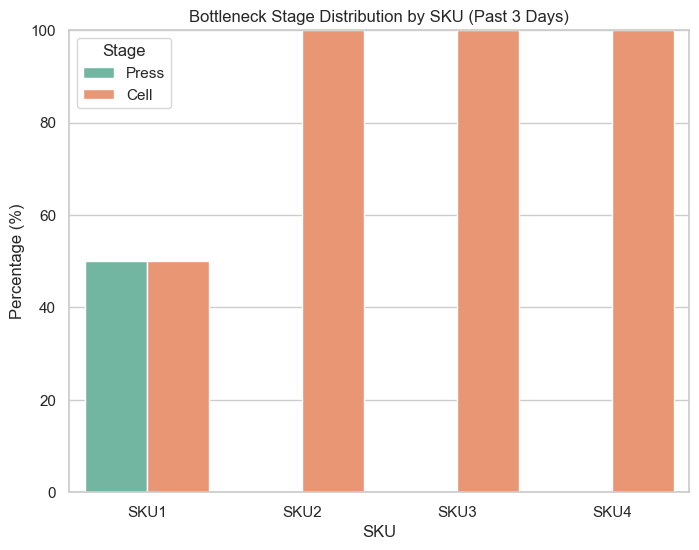

=== 과거 3일간 Actual vs Predicted (일치 여부 포함) + 오늘 예측 Stage ===

+----+-------+----------------------+--------------------+----------------------+--------------------+-------------+
|    | SKU   | 2025-06-27           | 2025-06-28         | 2025-06-29           | 2025-06-30         | 오늘_예측   |
+====+=======+======================+====================+======================+====================+=============+
|  0 | SKU1  | Press (예측:Press ✔) | Cell (예측:Cell ✔) | Press (예측:Press ✔) | Cell (예측:Cell ✔) | Cell        |
+----+-------+----------------------+--------------------+----------------------+--------------------+-------------+
|  1 | SKU2  | Cell (예측:Cell ✔)   | Cell (예측:Cell ✔) | Cell (예측:Cell ✔)   | Cell (예측:Cell ✔) | Cell        |
+----+-------+----------------------+--------------------+----------------------+--------------------+-------------+
|  2 | SKU3  | Cell (예측:Cell ✔)   | Cell (예측:Cell ✔) | Cell (예측:Cell ✔)   | Cell (예측:Cell ✔) | Cell        |
+----+-------+-----------------

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate

# ================================
# 1. 데이터 로드
# ================================
file_path = "./subset_20240101_20250630_fullcols.csv"
df = pd.read_csv(file_path)

# 날짜 변환
df["Time_Now"] = pd.to_datetime(df["Time_Now"])

# 하루당 1행만 남기기 (마지막 row 기준)
df_daily = df.groupby(df["Time_Now"].dt.date).tail(1).reset_index(drop=True)

# ================================
# 2. SKU 경로 및 Cell 매핑 정의
# ================================
sku_paths = {
    "SKU1": {"blanking": "Blanking_SKU1_Queue","press": "Press1_Queue"},
    "SKU2": {"blanking": "Blanking_SKU2_Queue","press": "Press2_Queue"},
    "SKU3": {"blanking": "Blanking_SKU3_Queue","press": "Press3_Queue"},
    "SKU4": {"blanking": "Blanking_SKU4_Queue","press": "Press4_Queue"},
}

cell_sku_map = {
    "Warehouse1_Queue": ["SKU1", "SKU2", "SKU4"],
    "Warehouse_2_Queue": ["SKU2", "SKU4"],
    "Warehouse_3_Queue": ["SKU2", "SKU3"],
    "Warehouse_4_Queue": ["SKU3", "SKU4"],
}

# ================================
# 3. Warehouse 분배 벡터화
# ================================
sku_cell_vals = {sku: pd.Series(0, index=df_daily.index) for sku in sku_paths}
for wh_col, skus in cell_sku_map.items():
    share = df_daily[wh_col] / len(skus)
    for s in skus:
        sku_cell_vals[s] += share

# ================================
# 4. 병목 Stage 라벨 생성
# ================================
labels = {}
for sku, path in sku_paths.items():
    stage_df = pd.DataFrame({
        "Blanking": df_daily[path["blanking"]],
        "Press": df_daily[path["press"]],
        "Cell": sku_cell_vals[sku]
    })
    labels[sku] = stage_df.fillna(float("-inf")).idxmax(axis=1)

# ================================
# 5. Feature 선택
# ================================
feature_cols = [
    "Blanking_SKU1_Queue","Blanking_SKU2_Queue","Blanking_SKU3_Queue","Blanking_SKU4_Queue",
    "Press1_Queue","Press2_Queue","Press3_Queue","Press4_Queue",
    "Warehouse1_Queue","Warehouse_2_Queue","Warehouse_3_Queue","Warehouse_4_Queue",
    "Forklift_Blanking_Queue","Forklift_Press_Queue","Forklift_Assembly_Queue"
]
X_full = df_daily[feature_cols]

# ================================
# 6. 과거 3일 필터링
# ================================
end_date = df_daily["Time_Now"].max()
start_date = end_date - pd.Timedelta(days=3)
df_past = df_daily[(df_daily["Time_Now"] >= start_date) & (df_daily["Time_Now"] <= end_date)]

# ================================
# 7. 과거 3일: SKU별 실제 병목 분포 (막대그래프, X=SKU)
# ================================
records = []
for sku in sku_paths.keys():
    past_labels = labels[sku].loc[df_past.index]
    counts = past_labels.value_counts(normalize=True) * 100

    if "Blanking" in counts and counts["Blanking"] < 5:
        counts = counts.drop("Blanking")

    for stage, val in counts.items():
        records.append({"SKU": sku, "Stage": stage, "Percentage": val})

plot_df = pd.DataFrame(records)

plt.figure(figsize=(8,6))
sns.barplot(data=plot_df, x="SKU", y="Percentage", hue="Stage", palette="Set2")
plt.title("Bottleneck Stage Distribution by SKU (Past 3 Days)")
plt.ylabel("Percentage (%)")
plt.xlabel("SKU")
plt.ylim(0, 100)
plt.legend(title="Stage")
plt.show()

# ================================
# 8. 과거 3일: 날짜별 Actual vs Predicted
# ================================
history_records = []

for sku in sku_paths.keys():
    y_past = labels[sku].loc[df_past.index]
    X_past = df_past[feature_cols]

    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_past, y_past)
    y_pred = clf.predict(X_past)

    for date, actual, pred in zip(df_past["Time_Now"].dt.date, y_past, y_pred):
        history_records.append({
            "Date": date,
            "SKU": sku,
            "Actual Stage": actual,
            "Predicted Stage": pred
        })

df_history = pd.DataFrame(history_records)

# ================================
# 9. 오늘 병목 Stage 예측
# ================================
df_today = df_daily[df_daily["Time_Now"].dt.date == end_date.date()]
X_today = df_today[feature_cols]

today_preds = {}
for sku in sku_paths.keys():
    y_all = labels[sku]
    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_full, y_all)
    pred_today = clf.predict(X_today)[0]
    today_preds[sku] = pred_today

df_history["Today Predicted Stage"] = df_history["SKU"].map(today_preds)

# -------------------------------
# 10. 출력 (날짜별 1컬럼: 실제 + 예측 + 일치여부)
# -------------------------------
records_summary = []

for sku in sku_paths.keys():
    y_past = labels[sku].loc[df_past.index]
    X_past = df_past[feature_cols]

    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_past, y_past)
    y_pred = clf.predict(X_past)

    # 날짜별 기록
    for date, actual, pred in zip(df_past["Time_Now"].dt.date, y_past, y_pred):
        match = "✔" if actual == pred else "❌"
        cell_value = f"{actual} (예측:{pred} {match})"
        records_summary.append({"SKU": sku, "Date": date, "Result": cell_value})

df_summary = pd.DataFrame(records_summary)

# Pivot → 날짜별 1개 컬럼만
df_pivot = df_summary.pivot(index="SKU", columns="Date", values="Result").reset_index()

# 오늘 예측 추가
df_pivot["오늘_예측"] = df_pivot["SKU"].map(today_preds)

# 출력
print("=== 과거 3일간 Actual vs Predicted (일치 여부 포함) + 오늘 예측 Stage ===\n")
print(tabulate(df_pivot, headers="keys", tablefmt="grid"))

# -------------------------------
# 11. 저장 (엑셀/CSV)
# -------------------------------
output_path = "./bottleneck_summary.xlsx"
df_pivot.to_excel(output_path, index=False)
print(f"\n👉 결과를 엑셀로 저장했습니다: {output_path}")

In [41]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 설정 (Windows: 맑은 고딕, Mac: AppleGothic, Linux: NanumGothic 등)
plt.rcParams['font.family'] = 'Malgun Gothic'   # Windows
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac
# plt.rcParams['font.family'] = 'NanumGothic'  # Linux

# 마이너스 기호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

In [42]:
import matplotlib as mpl
from matplotlib import font_manager

# 사용할 폰트 후보
font_candidates = ["Malgun Gothic", "NanumGothic", "AppleGothic", "Noto Sans CJK KR"]

for f in font_candidates:
    if f in [x.name for x in font_manager.fontManager.ttflist]:
        mpl.rc("font", family=f)
        break

mpl.rcParams["axes.unicode_minus"] = False  # 마이너스 기호 깨짐 방지

=== 과거 3일간 공정별 Actual vs Predicted (일치 여부 포함) + 오늘 예측 ===

+----+--------------+--------------------+--------------------+--------------------+--------------------+-------------+
|    | StageGroup   | 2025-06-27         | 2025-06-28         | 2025-06-29         | 2025-06-30         | 오늘_예측   |
+====+==============+====================+====================+====================+====================+=============+
|  0 | Blanking     | SKU1 (예측:SKU1 ✔) | SKU4 (예측:SKU4 ✔) | SKU4 (예측:SKU4 ✔) | SKU4 (예측:SKU4 ✔) | SKU4        |
+----+--------------+--------------------+--------------------+--------------------+--------------------+-------------+
|  1 | Press        | P1 (예측:P1 ✔)     | P2 (예측:P2 ✔)     | P1 (예측:P1 ✔)     | P2 (예측:P2 ✔)     | P2          |
+----+--------------+--------------------+--------------------+--------------------+--------------------+-------------+
|  2 | Warehouse    | W1 (예측:W1 ✔)     | W1 (예측:W1 ✔)     | W1 (예측:W1 ✔)     | W1 (예측:W1 ✔)     | W1          |
+----+---

C:\Users\KDT6\AppData\Local\Temp\ipykernel_21544\3055458981.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, fontweight="bold")


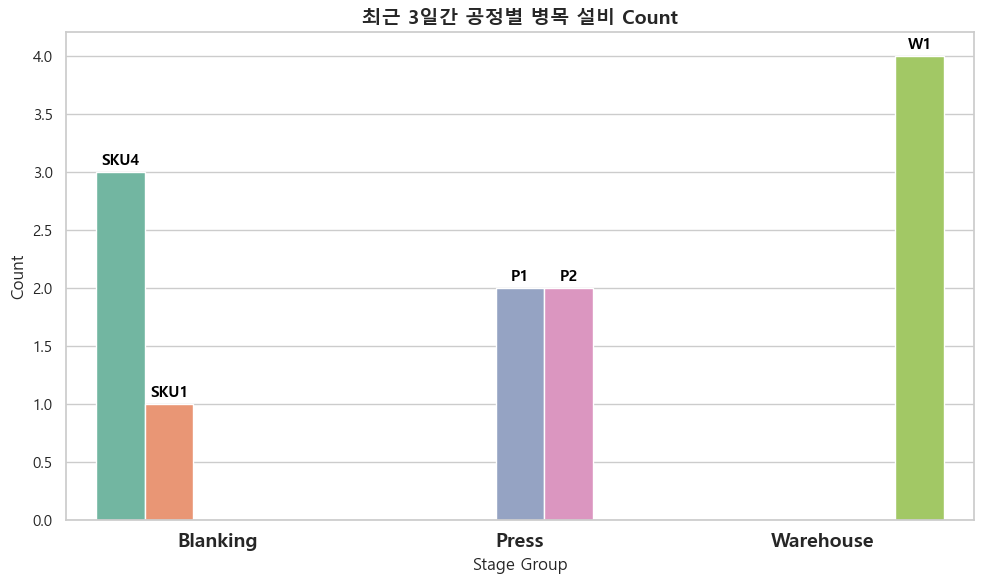

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate

# ================================
# 0. 유틸 함수
# ================================
def clean_name(x: str) -> str:
    """_Queue, Blanking_, Press, Warehouse 접두사 제거"""
    x = str(x)
    x = x.replace("_Queue", "")
    x = x.replace("Blanking_", "")
    x = x.replace("Press", "P")        # Press1 → P1
    x = x.replace("Warehouse_", "W")   # Warehouse_2 → W2
    x = x.replace("Warehouse", "W")    # Warehouse1 → W1
    return x

# ================================
# 1. 공정 그룹 정의
# ================================
stage_groups = {
    "Blanking": [f"Blanking_SKU{i}_Queue" for i in range(1,5)],
    "Press": [f"Press{i}_Queue" for i in range(1,5)],
    "Warehouse": [f"Warehouse{i}_Queue" if i==1 else f"Warehouse_{i}_Queue" for i in range(1,5)]
}

# ================================
# 2. 병목 라벨 생성 (실제값)
# ================================
labels_stage = {}
for stage, cols in stage_groups.items():
    labels_stage[stage] = df_daily[cols].idxmax(axis=1)

# ================================
# 3. 과거 3일 필터링
# ================================
end_date = df_daily["Time_Now"].max()
start_date = end_date - pd.Timedelta(days=3)
df_past = df_daily[(df_daily["Time_Now"] >= start_date) & (df_daily["Time_Now"] <= end_date)]

# ================================
# 4. 과거 3일: Actual vs Predicted (공정별)
# ================================
records_stage = []

for stage, cols in stage_groups.items():
    y_past = labels_stage[stage].loc[df_past.index]
    X_past = df_past[feature_cols]

    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_past, y_past)
    y_pred = clf.predict(X_past)

    for date, actual, pred in zip(df_past["Time_Now"].dt.date, y_past, y_pred):
        match = "✔" if actual == pred else "❌"
        cell_value = f"{clean_name(actual)} (예측:{clean_name(pred)} {match})"
        records_stage.append({"StageGroup": stage, "Date": date, "Result": cell_value})

df_stage_summary = pd.DataFrame(records_stage)

# ================================
# 5. Pivot: 날짜별 1컬럼씩
# ================================
df_stage_pivot = df_stage_summary.pivot(index="StageGroup", columns="Date", values="Result").reset_index()

# 오늘 예측 추가
today_preds_stage = {}
df_today = df_daily[df_daily["Time_Now"].dt.date == end_date.date()]
X_today = df_today[feature_cols]

for stage, cols in stage_groups.items():
    y_all = labels_stage[stage]
    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_full, y_all)
    pred_today = clf.predict(X_today)[0]
    today_preds_stage[stage] = clean_name(pred_today)

df_stage_pivot["오늘_예측"] = df_stage_pivot["StageGroup"].map(today_preds_stage)

# ================================
# 6. 출력
# ================================
print("=== 과거 3일간 공정별 Actual vs Predicted (일치 여부 포함) + 오늘 예측 ===\n")
print(tabulate(df_stage_pivot, headers="keys", tablefmt="grid"))

# ================================
# 7. 과거 3일: 공정별 실제 병목 분포 (막대그래프, X=StageGroup)
# ================================
records = []
for stage, cols in stage_groups.items():
    past_labels = labels_stage[stage].loc[df_past.index]
    counts = past_labels.value_counts()

    for eq, val in counts.items():
        records.append({
            "StageGroup": stage,
            "Equipment": clean_name(eq),
            "Count": val
        })

plot_df = pd.DataFrame(records)

plt.figure(figsize=(10,6))
ax = sns.barplot(data=plot_df, x="StageGroup", y="Count", hue="Equipment", palette="Set2")

# 막대 끝에 라벨 표시
for p, (stage, eq) in zip(ax.patches, plot_df[["StageGroup","Equipment"]].values):
    ax.annotate(eq,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=11, fontweight="bold", color="black",
                xytext=(0, 2), textcoords="offset points")

# 축 라벨 및 타이틀
ax.set_ylabel("Count", fontsize=12)
ax.set_xlabel("Stage Group", fontsize=12)
ax.set_title("최근 3일간 공정별 병목 설비 Count", fontsize=14, fontweight="bold")

# X축 눈금(label) 크게 설정
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, fontweight="bold")

# 범례 제거
ax.legend_.remove()
plt.tight_layout()
plt.show()

=== 과거 3일간 공정별 Actual vs Predicted (일치 여부 포함) + 오늘 예측 ===

+----+--------------+----------------------+----------------------+----------------------+----------------------+-------------+
|    | StageGroup   | 2025-06-27           | 2025-06-28           | 2025-06-29           | 2025-06-30           | 오늘_예측   |
+====+==============+======================+======================+======================+======================+=============+
|  0 | Blanking     | SKU1 (예측:SKU1 ✔)   | SKU4 (예측:SKU4 ✔)   | SKU4 (예측:SKU4 ✔)   | SKU4 (예측:SKU4 ✔)   | SKU4        |
+----+--------------+----------------------+----------------------+----------------------+----------------------+-------------+
|  1 | Press        | P1 (예측:P1 ✔)       | P2 (예측:P2 ✔)       | P1 (예측:P1 ✔)       | P2 (예측:P2 ✔)       | P2          |
+----+--------------+----------------------+----------------------+----------------------+----------------------+-------------+
|  2 | Cell         | Cell1 (예측:Cell1 ✔) | Cell1 (예측:Cell1 ✔) | C

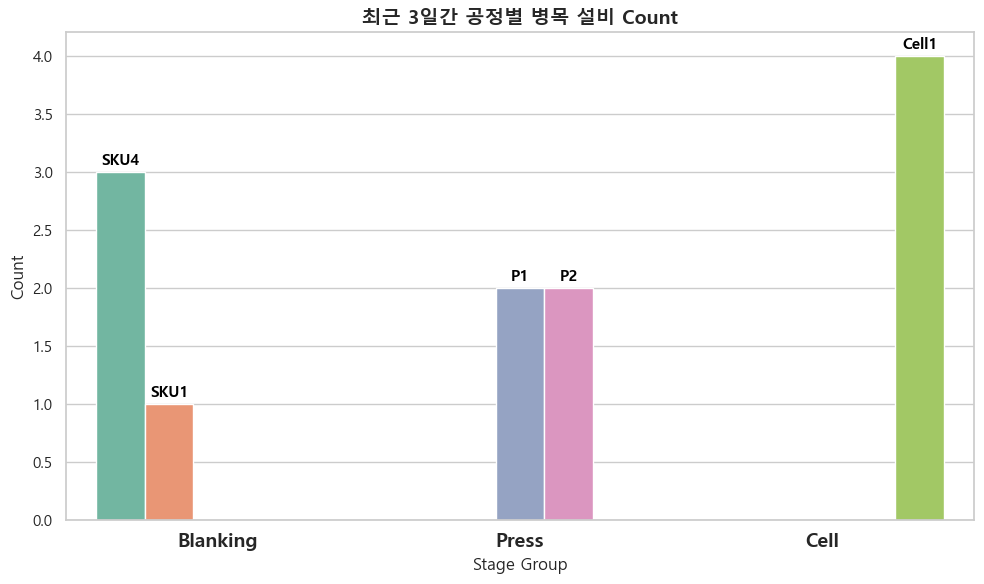

In [45]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate

# ================================
# 0. 유틸 함수
# ================================
def clean_name(x: str) -> str:
    """_Queue, Blanking_, Press, Warehouse 접두사 제거 + Warehouse → Cell"""
    x = str(x)
    x = x.replace("_Queue", "")
    x = x.replace("Blanking_", "")
    x = x.replace("Press", "P")             # Press1 → P1
    x = x.replace("Warehouse_", "Cell")     # Warehouse_2 → Cell2
    x = x.replace("Warehouse", "Cell")      # Warehouse1 → Cell1
    return x

# ================================
# 1. 공정 그룹 정의
# ================================
stage_groups = {
    "Blanking": [f"Blanking_SKU{i}_Queue" for i in range(1,5)],
    "Press": [f"Press{i}_Queue" for i in range(1,5)],
    "Cell": [f"Warehouse{i}_Queue" if i==1 else f"Warehouse_{i}_Queue" for i in range(1,5)]
}

# ================================
# 2. 병목 라벨 생성 (실제값)
# ================================
labels_stage = {}
for stage, cols in stage_groups.items():
    labels_stage[stage] = df_daily[cols].idxmax(axis=1)

# ================================
# 3. 과거 3일 필터링
# ================================
end_date = df_daily["Time_Now"].max()
start_date = end_date - pd.Timedelta(days=3)
df_past = df_daily[(df_daily["Time_Now"] >= start_date) & (df_daily["Time_Now"] <= end_date)]

# ================================
# 4. 과거 3일: Actual vs Predicted (공정별)
# ================================
records_stage = []

for stage, cols in stage_groups.items():
    y_past = labels_stage[stage].loc[df_past.index]
    X_past = df_past[feature_cols]

    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_past, y_past)
    y_pred = clf.predict(X_past)

    for date, actual, pred in zip(df_past["Time_Now"].dt.date, y_past, y_pred):
        match = "✔" if actual == pred else "❌"
        cell_value = f"{clean_name(actual)} (예측:{clean_name(pred)} {match})"
        records_stage.append({"StageGroup": stage, "Date": date, "Result": cell_value})

df_stage_summary = pd.DataFrame(records_stage)

# ================================
# 5. Pivot: 날짜별 1컬럼씩
# ================================
df_stage_pivot = df_stage_summary.pivot(index="StageGroup", columns="Date", values="Result").reset_index()

# 오늘 예측 추가
today_preds_stage = {}
df_today = df_daily[df_daily["Time_Now"].dt.date == end_date.date()]
X_today = df_today[feature_cols]

for stage, cols in stage_groups.items():
    y_all = labels_stage[stage]
    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_full, y_all)
    pred_today = clf.predict(X_today)[0]
    today_preds_stage[stage] = clean_name(pred_today)

df_stage_pivot["오늘_예측"] = df_stage_pivot["StageGroup"].map(today_preds_stage)

# ================================
# 6. 출력 (StageGroup 순서 보장)
# ================================
print("=== 과거 3일간 공정별 Actual vs Predicted (일치 여부 포함) + 오늘 예측 ===\n")

order = ["Blanking", "Press", "Cell"]
df_stage_pivot["StageGroup"] = pd.Categorical(df_stage_pivot["StageGroup"], categories=order, ordered=True)
df_stage_pivot = df_stage_pivot.sort_values("StageGroup").reset_index(drop=True)

print(tabulate(df_stage_pivot, headers="keys", tablefmt="grid"))

# ================================
# 7. 과거 3일: 공정별 실제 병목 분포 (막대그래프, X=StageGroup)
# ================================
records = []
for stage, cols in stage_groups.items():
    past_labels = labels_stage[stage].loc[df_past.index]
    counts = past_labels.value_counts()

    for eq, val in counts.items():
        records.append({
            "StageGroup": stage,
            "Equipment": clean_name(eq),
            "Count": val
        })

plot_df = pd.DataFrame(records)

plt.figure(figsize=(10,6))
ax = sns.barplot(data=plot_df, x="StageGroup", y="Count", hue="Equipment", palette="Set2")

# 막대 끝에 라벨 표시
for p, (stage, eq) in zip(ax.patches, plot_df[["StageGroup","Equipment"]].values):
    ax.annotate(eq,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=11, fontweight="bold", color="black",
                xytext=(0, 2), textcoords="offset points")

# 축 라벨 및 타이틀
ax.set_ylabel("Count", fontsize=12)
ax.set_xlabel("Stage Group", fontsize=12)
ax.set_title("최근 3일간 공정별 병목 설비 Count", fontsize=14, fontweight="bold")

# X축 눈금(label) 크게 설정 (set_xticklabels 대신 tick_params 사용)
ax.tick_params(axis="x", labelsize=14)
for label in ax.get_xticklabels():
    label.set_fontweight("bold")

# 범례 제거
ax.legend_.remove()
plt.tight_layout()
plt.show()